# Financial data indices

In [1]:
import json
import math
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})

In [3]:
"""
Some saliencies are virtually 0. 
Here we filter for a given tolerance so that to avoid these values.
"""
def filter_positive(dictionary, key, tol = 0.):
    sal = dictionary[key]
    return { k: v for (k, v) in sal.items() if v > tol }

### Read data generated by .py scripts

In [4]:
with open("../data/saliency.json") as file:
    saliency = json.load(file)


summand_dws =  { key: value + saliency["ANNUAL dws b"].get(key, 0.) for key, value in saliency["ANNUAL dws"].items() }    
saliency["ANNUAL dws"] = { **saliency["ANNUAL dws b"], **summand_dws }

saliency.pop("ANNUAL dws b")

# Combine DWS-a and DWS-b

reports = list(saliency)

saliency = {company: filter_positive(saliency, company, tol=0) for company in reports}

FileNotFoundError: [Errno 2] No such file or directory: '../data/saliency.json'

In [ ]:
types = ["ANNUAL", "RI_REPORT", "STEWARDSHIP_POLICY", "VOTING_POLICY"]
companies = set()

for report in reports:
    name = report
    for t in types:
        name = name.replace(f"{t} ", "")
        
    companies.add(name)
    
companies = list(companies)

In [ ]:
companies

['nn', 'apg', 'nbim', 'blackrock', 'dws', 'jpmam', 'generali']

## Distribution of all saliencies

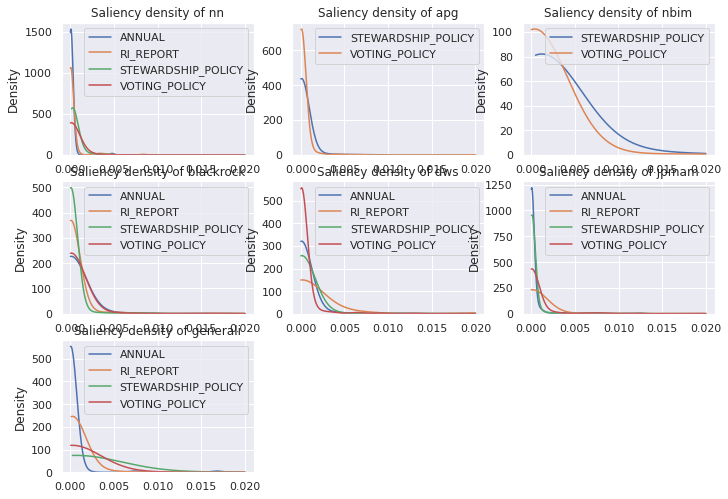

In [ ]:
columns = 3
rows = math.ceil(len(companies) / columns)

fig, axes = plt.subplots(rows, columns)

for i, ax in enumerate(axes.flat):    
    if i < len(companies):
        company = companies[i]
        labels = []

        for t in types:
            key = f"{t} {company}"
            
            if key in saliency:
                data = list(saliency[key].values())
                lower = min(data)
                upper = .02
                
                if np.var(data) > 0:
                    sns.kdeplot(data, ax = ax, clip=(lower, upper))
                    labels.append(t)
            
        
        ax.legend(labels)
        ax.set_title(f"Saliency density of {company}")
        
    else:
        # Delete empty axes
        fig.delaxes(ax)
    
fig.show()
fig.savefig("../plots/saliencies/saliencies_dist.svg")

## Lenght of documents

In [ ]:
groups = types

In [ ]:
grouped_data = { g: {} for g in groups }

for report in reports:
    for group in groups:
        if group in report:
            company = report.replace(f"{group} ", "")
            grouped_data[group][company] = len(saliency[report])
            
            continue
            
size_df = pd.DataFrame.from_dict(grouped_data)

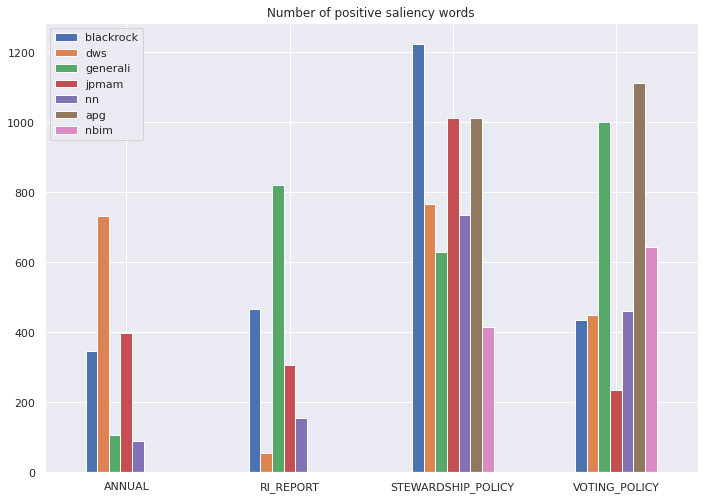

In [ ]:
fig, ax = plt.subplots()

size_df.T.plot.bar(rot=0, ax=ax)
ax.set_title("Number of positive saliency words")

fig.show()
fig.savefig("../plots/saliencies/positive_saliency.svg")

## Sustainable index, data extraction

In [ ]:
sustainable_words = [
    "climate", "green", 
    "sustainable", "sustainability",  
    "environment", "environmental"
]

In [ ]:
"""
Computes the saliency index for the words provided
"""
def index(saliency, report, words, **kwargs):
    
    def inword(k):
        for word in words:
            if word in k:
                return word
        
        return False
        
    isinwords = lambda k: any(word in k for word in words)
    
    sal = filter_positive(saliency, report, **kwargs)
    
    total = sum(sal.values())
    sustainable = { inword(k): v for (k, v) in sal.items() if inword(k) }
    
    return { "total": total, **sustainable }

In [ ]:
def make_index(saliency, groups, reports, sustainable_words):

    grouped_data = { g: {} for g in groups }

    for group in groups:
        dfgroup = {}
        for report in reports:
            if group in report:
                company = report.replace(f"{group} ", "")
                dfgroup[company] = index(saliency, report, sustainable_words)

                continue

        groupdf = pd.DataFrame.from_dict(dfgroup).fillna(0.)
        groupdf.loc["s-index"] = groupdf.loc[groupdf.index != "total"].sum()
        groupdf = groupdf.drop("total", axis = 0)
        grouped_data[group] = groupdf


    df = pd.concat(grouped_data).fillna(0.)
    
    return df

In [ ]:
df = make_index(saliency, groups, reports, sustainable_words)

## Sustainability index

In [ ]:
total_df = df.swaplevel().loc["s-index"]

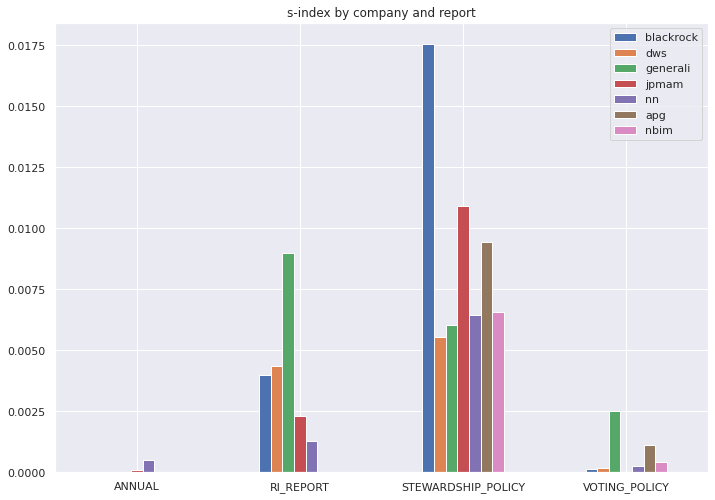

In [ ]:
fig, ax = plt.subplots()

total_df.plot.bar(rot=0, ax=ax)
ax.set_title("s-index by company and report")

fig.show()
fig.savefig("../plots/saliencies/sustainable_saliency.svg")

## Index breakdown

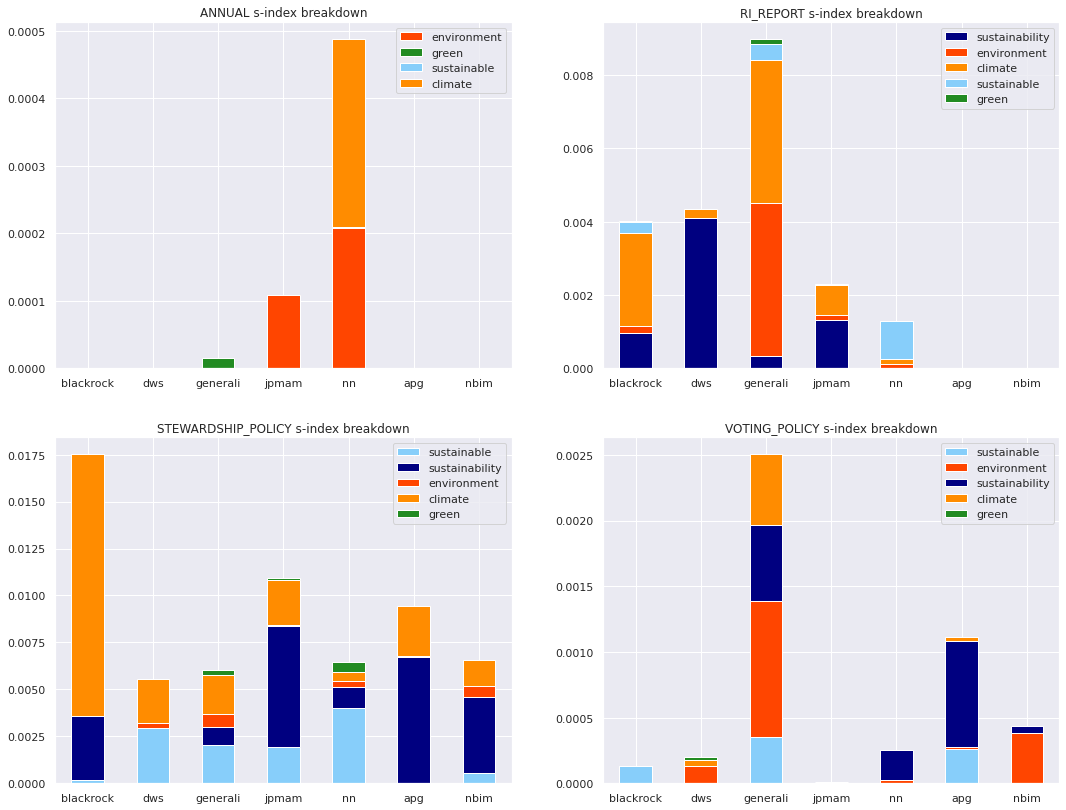

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

colors = {
    "environment": "orangered",
    "green": "forestgreen",
    "sustainable": "lightskyblue",
    "sustainability": "navy",
    "climate": "darkorange",
    
}

for i, ax in enumerate(axes.flat):
    group = groups[i]
    groupdf = df.loc[group].iloc[df.loc[group].index != "s-index"]

    groupdf.T.plot(kind='bar', stacked=True, ax = ax, rot = 0, color=colors)
    ax.set_title(f"{group} s-index breakdown")


fig.show()
fig.savefig("../plots/saliencies/breakdown.svg")